<a href="https://colab.research.google.com/github/Kryptera-K/DIA-Woodies-Confluence-Breakdown-Strategy-WCB-/blob/main/DIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "DIA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("DIA_clean.csv", index=False)
df

/tmp/ipython-input-491781375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,65.091232,66.542881,64.804487,66.542881,1278800
2000-01-04,62.949562,64.786524,62.949562,64.392250,1535700
2000-01-05,63.764973,64.445993,62.528384,63.083953,2007000
2000-01-06,64.087677,64.903110,63.765088,63.890539,2639500
2000-01-07,66.238220,66.274063,64.929944,64.983708,3767400
...,...,...,...,...,...
2025-11-21,462.570007,465.820007,457.850006,459.540009,11821400
2025-11-24,464.440002,465.869995,461.010010,463.750000,6206800
2025-11-25,471.179993,471.899994,463.450012,465.579987,7203600


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BULL_EMA_PERIOD = 13
BULL_LEVEL = 0
DEM_LEVEL = 0.5
DEM_PERIOD = 14
DEM_SHIFT_1 = 5
DEM_SHIFT_2 = 10
DEM_SHIFT_3 = 15
WOODIE_CCI_PERIOD = 14
WOODIE_FAST_PERIOD = 6
WOODIE_SHIFT = 5
WOODIE_SLOW_PERIOD = 34

# -------------------------
# Indicator Functions
# -------------------------

def bull_power_is_falling(df, EMA_PERIOD=BULL_EMA_PERIOD):
    df = calculate_bull_power(df, EMA_PERIOD)
    return df['Bull_Power'].diff() < 0


def calculate_bull_power(df, EMA_PERIOD=BULL_EMA_PERIOD):
    """
    Calculate Bull Power indicator.
    Bull Power = High - EMA(Close)
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df['Bull_Power'] = df['High'] - df['EMA']
    return df


def woodies_famir_down(df, fast_period=WOODIE_FAST_PERIOD, slow_period=WOODIE_SLOW_PERIOD, shifts=WOODIE_SHIFT):
    df['CCI_fast'] = calculate_woodie_cci(df, fast_period)['CCI']
    df['CCI_slow'] = calculate_woodie_cci(df, slow_period)['CCI']
    return (df['CCI_fast'] < df['CCI_slow']) & \
           (df['CCI_fast'].shift(shifts) >= df['CCI_slow'].shift(shifts))


def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def demarker_cross_below_level(df, level=DEM_LEVEL, shift_1=DEM_SHIFT_1, shift_2=DEM_SHIFT_2):
    df = calculate_demarker(df)
    return (df['DeMarker'].shift(shift_2) > level) & \
           (df['DeMarker'].shift(shift_1) < level)


def calculate_demarker(df, period=DEM_PERIOD):
    """
    Calculate DeMarker indicator.
    """
    df = df.copy()

    # DeMax and DeMin
    df['DeMax'] = np.where(df['High'] > df['High'].shift(1),
                           df['High'] - df['High'].shift(1), 0)
    df['DeMin'] = np.where(df['Low'] < df['Low'].shift(1),
                           df['Low'].shift(1) - df['Low'], 0)

    # Rolling sums
    dem_max = df['DeMax'].rolling(window=period).sum()
    dem_min = df['DeMin'].rolling(window=period).sum()

    df['DeMarker'] = dem_max / (dem_max + dem_min)
    return df


def woodies_zlr_up(df, period=WOODIE_FAST_PERIOD):
    df['CCI_main'] = calculate_woodie_cci(df, period)['CCI']
    return (df['CCI_main'] > 0) & (df['CCI_main'].shift(1) <= 0)



# -------------------------
# Entry conditions
# -------------------------

df["BullP_Falling"] = bull_power_is_falling(df)
df["Woodies_Famir_Down"] = woodies_famir_down(df)

# -------------------------
# Exit conditions
# -------------------------

df["Demarker_Cross_Below_Level"] = demarker_cross_below_level(df)
df["Woodies_ZLR_Up"] = woodies_zlr_up(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BullP_Falling',
    'Woodies_Famir_Down',
]
exit_conditions = [
    'Demarker_Cross_Below_Level',
    'Woodies_ZLR_Up',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-11-28 00:00:00
Period                                6517 days 00:00:00
Start Value                                     100000.0
End Value                                  991187.532237
Total Return [%]                              891.187532
Benchmark Return [%]                          613.554924
Max Gross Exposure [%]                             100.0
Total Fees Paid                             65848.401817
Max Drawdown [%]                               29.018255
Max Drawdown Duration                  646 days 00:00:00
Total Trades                                          85
Total Closed Trades                                   85
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   68.235294
Best Trade [%]                                 37.975341
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-11-28 00:00:00
Period                         6517 days 00:00:00
Start Value                              100000.0
End Value                           713554.923946
Total Return [%]                       613.554924
Benchmark Return [%]                   613.554924
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        51.755601
Max Drawdown Duration          1239 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      613554.923946
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-686472227.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


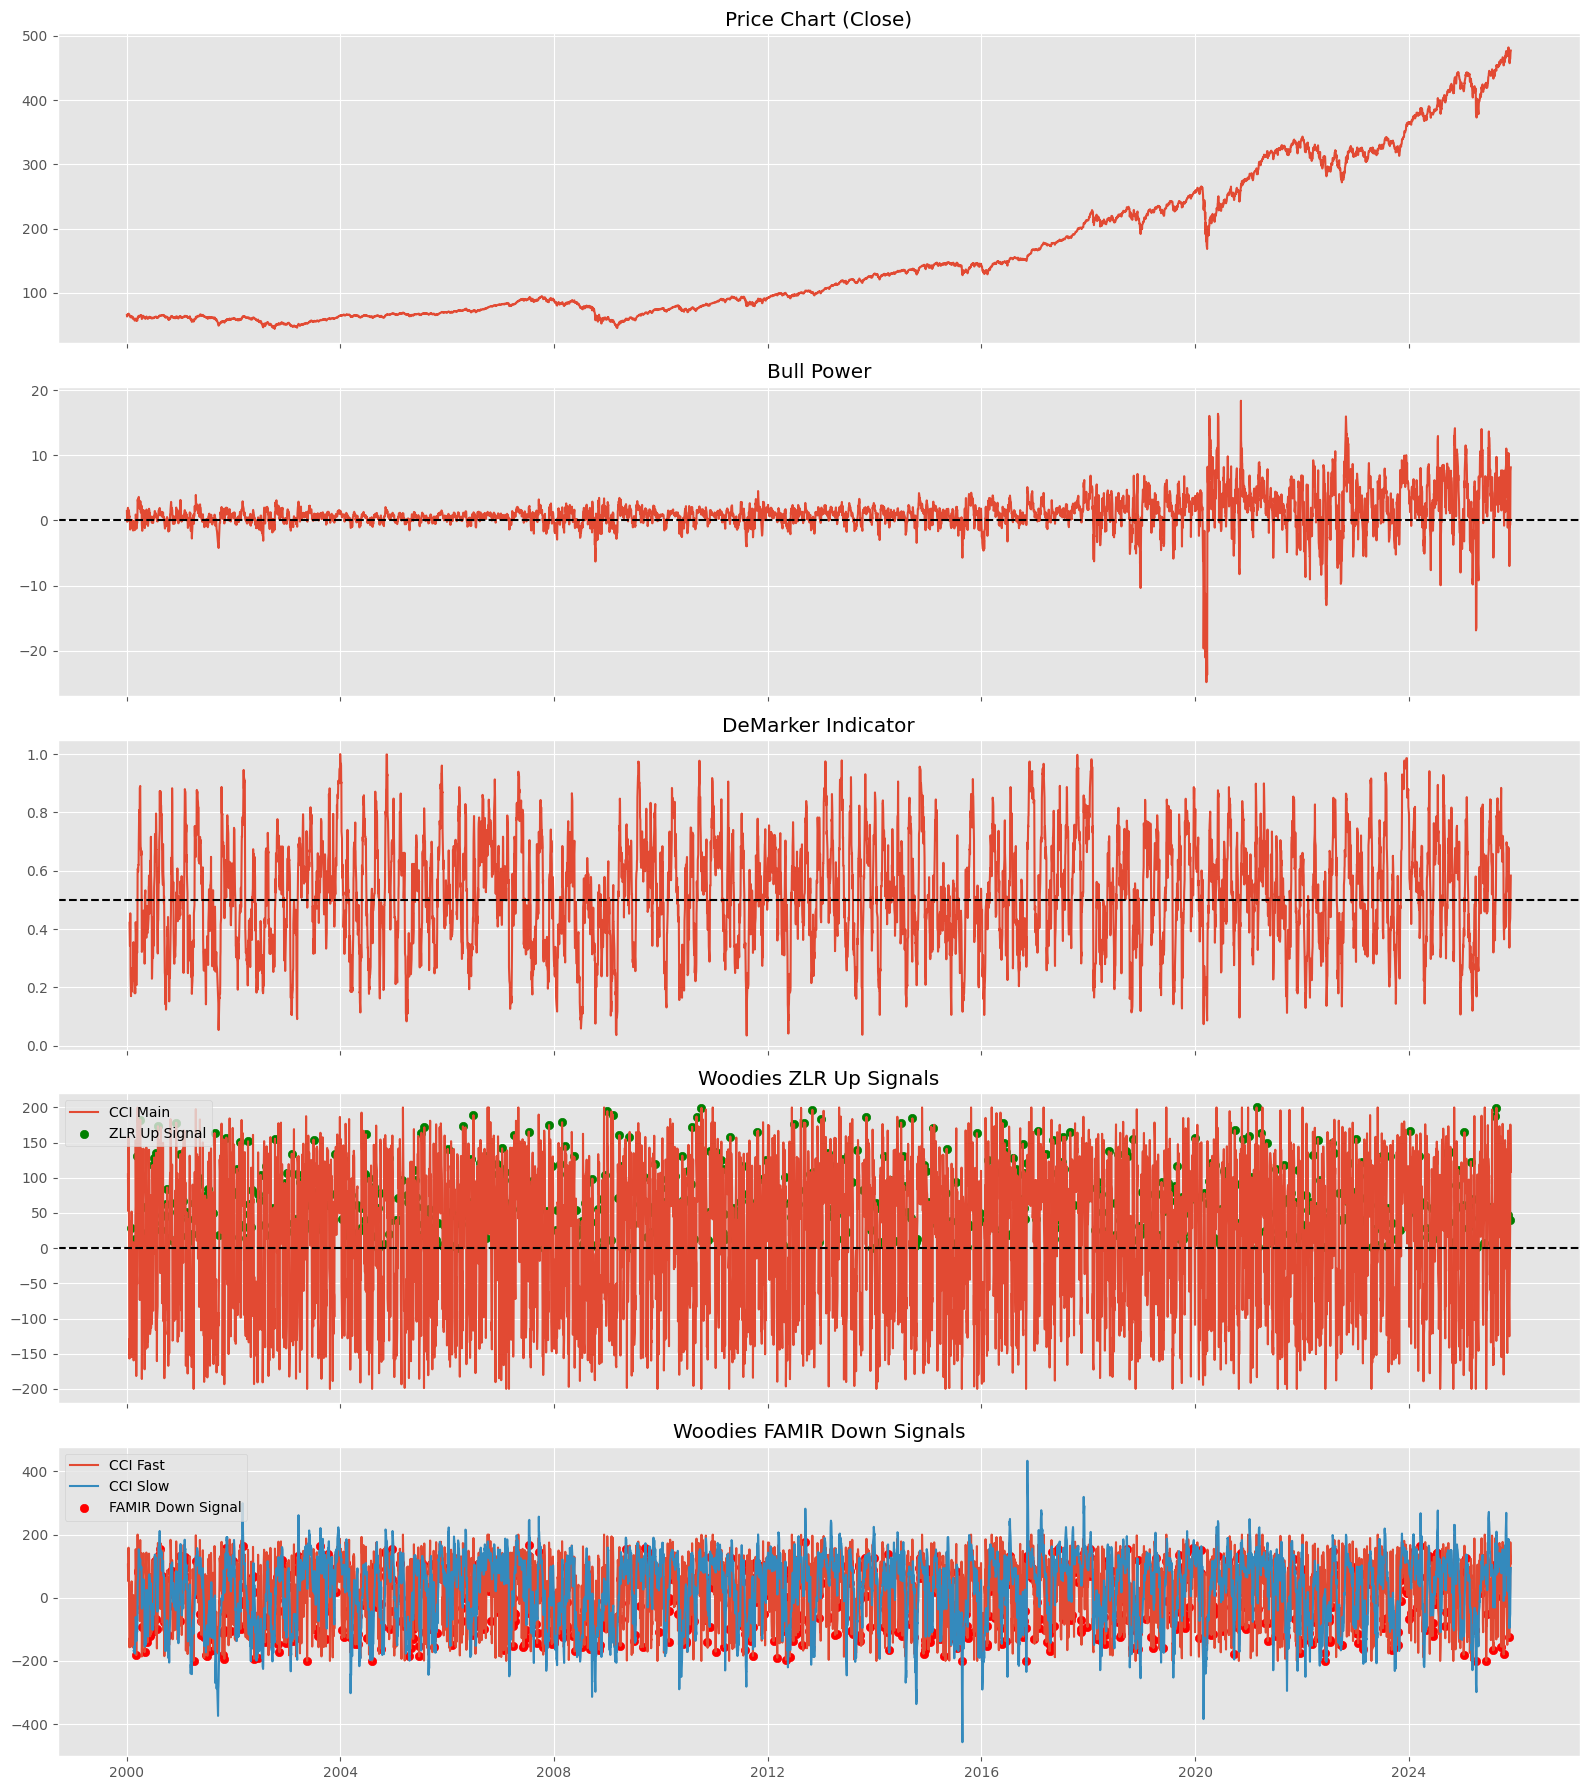

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "DIA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------

BULL_EMA_PERIOD = 13
BULL_LEVEL = 0

DEM_LEVEL = 0.5
DEM_PERIOD = 14
DEM_SHIFT_1 = 5
DEM_SHIFT_2 = 10
DEM_SHIFT_3 = 15

WOODIE_CCI_PERIOD = 14
WOODIE_FAST_PERIOD = 6
WOODIE_SHIFT = 5
WOODIE_SLOW_PERIOD = 34

# -------------------------
# Indicator Functions
# -------------------------

def calculate_bull_power(df, EMA_PERIOD=BULL_EMA_PERIOD):
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df['Bull_Power'] = df['High'] - df['EMA']
    return df

def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df[['CCI']]

def calculate_demarker(df, period=DEM_PERIOD):
    df = df.copy()
    df['DeMax'] = np.where(df['High'] > df['High'].shift(1),
                           df['High'] - df['High'].shift(1), 0)
    df['DeMin'] = np.where(df['Low'] < df['Low'].shift(1),
                           df['Low'].shift(1) - df['Low'], 0)
    dem_max = df['DeMax'].rolling(window=period).sum()
    dem_min = df['DeMin'].rolling(window=period).sum()
    df['DeMarker'] = dem_max / (dem_max + dem_min)
    return df

# -------------------------
# Compute All Indicators
# -------------------------

df = calculate_bull_power(df)
df['DeMarker'] = calculate_demarker(df)['DeMarker']

df['CCI_fast'] = calculate_woodie_cci(df, WOODIE_FAST_PERIOD)['CCI']
df['CCI_slow'] = calculate_woodie_cci(df, WOODIE_SLOW_PERIOD)['CCI']
df['CCI_main'] = calculate_woodie_cci(df, WOODIE_FAST_PERIOD)['CCI']

df['ZLR_up'] = (df['CCI_main'] > 0) & (df['CCI_main'].shift(1) <= 0)
df['FAMIR_down'] = (df['CCI_fast'] < df['CCI_slow']) & \
                    (df['CCI_fast'].shift(WOODIE_SHIFT) >= df['CCI_slow'].shift(WOODIE_SHIFT))

# -------------------------
# Plotting
# -------------------------

plt.style.use("ggplot")
fig, axs = plt.subplots(5, 1, figsize=(16, 18), sharex=True)

# 1. Price
axs[0].plot(df.index, df['Close'], label="Close")
axs[0].set_title("Price Chart (Close)")

# 2. Bull Power
axs[1].plot(df.index, df['Bull_Power'], label="Bull Power")
axs[1].axhline(BULL_LEVEL, color="black", linestyle="--")
axs[1].set_title("Bull Power")

# 3. DeMarker
axs[2].plot(df.index, df['DeMarker'], label="DeMarker")
axs[2].axhline(DEM_LEVEL, color="black", linestyle="--")
axs[2].set_title("DeMarker Indicator")

# 5. Woodies ZLR
axs[3].plot(df.index, df['CCI_main'], label="CCI Main")
axs[3].scatter(df.index[df['ZLR_up']], df['CCI_main'][df['ZLR_up']], color="green", label="ZLR Up Signal")
axs[3].axhline(0, color="black", linestyle="--")
axs[3].legend()
axs[3].set_title("Woodies ZLR Up Signals")

# 6. Woodies FAMIR
axs[4].plot(df.index, df['CCI_fast'], label="CCI Fast")
axs[4].plot(df.index, df['CCI_slow'], label="CCI Slow")
axs[4].scatter(df.index[df['FAMIR_down']], df['CCI_fast'][df['FAMIR_down']], color="red", label="FAMIR Down Signal")
axs[4].legend()
axs[4].set_title("Woodies FAMIR Down Signals")

plt.tight_layout()
plt.show()
